# Purpose Statement

This Notebook Introduces how to download our Benchmark datasets and a single benchmark method for post-processing an Ensemble forecast (EMOS), it is based on the 2018 paper by Stephan Rasp and Sebastian Lerch. Please see their paper for an exploration of the EMOS system we use here, and other interesting methods for post-process bench marking. A brief description is also below:

Rasp & Lerch github for relevant code: [GITHUB](https://github.com/slerch/ppnn)

Paper URL: [Rasp & Lerch 2018](https://arxiv.org/abs/1805.09091)

#### Ensemble Model Output Statistics (EMOS)

---
Ensemble Model Output Statistics post-processing  is a non-homogeneous regression which (EMOS; Gneiting et al., 2005), relies on parametric forecast distributions. One specifies a predictive distribution and estimate its parameters. In the EMOS framework the distribution parameters are connected to summary statistics of the ensemble predictions through suitable link functions which are estimated by minimizing a probabilistic loss function over a training dataset. We will utilize the KERAS training framework in order to specify and learn this linking function. 

#### CRPS as a 'Proper Scoring' Metric for Ensemble Evaluation
----

We use CRPS as a scoring metric to evaluate the Ensemble predictions. We are assuming a parametric normal distribution for the PNA forecast and applying the CRPS methods as seen in Rasp & Lerch 2018 appendix.

See Rasp & Lerch for an evaluation of CRPS as a Proper scoring metric 

Paper URL: [Rasp & Lerch 2018](https://arxiv.org/abs/1805.09091)

## Import Necessary Packages:

In [46]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import time
import xarray as xr
from netCDF4 import Dataset
from scipy.stats import rankdata



import keras
from keras.layers import Input, Dense, merge, Embedding, Flatten, Concatenate
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
import keras.backend as K
from keras.callbacks import EarlyStopping

if keras.backend.backend() == 'tensorflow':
    from tensorflow import erf
else:
    from theano.tensor import erf
# import utils

import random 
random.seed(1) #for reproduceability. 

import seaborn as sns
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})


## Functions We Will Need to Evaluate and Train Our EMOS model:

In [63]:
def crps_cost_function(y_true, y_pred, theano=False):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.
    Code inspired by Kai Polsterer (HITS).
    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]
        theano: Set to true if using this with pure theano.
    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """

    # Split input
    mu = y_pred[:, 0]
    sigma = y_pred[:, 1]
    # Ugly workaround for different tensor allocation in keras and theano
    if not theano:
        y_true = y_true[:, 0]   # Need to also get rid of axis 1 to match!

    # To stop sigma from becoming negative we first have to 
    # convert it the the variance and then take the square
    # root again. 
    var = K.square(sigma)
    # The following three variables are just for convenience
    loc = (y_true - mu) / K.sqrt(var)
    phi = 1.0 / np.sqrt(2.0 * np.pi) * K.exp(-K.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + erf(loc / np.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  K.sqrt(var) * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return K.mean(crps)



def build_EMOS_network_keras(compile=False, optimizer='sgd', lr=0.1):
    """Build (and maybe compile) EMOS network in keras.
    Args:
        compile: If true, compile model
        optimizer: String of keras optimizer
        lr: learning rate
    Returns:
        model: Keras model
    """
    mean_in = Input(shape=(1,))
    std_in = Input(shape=(1,))
    mean_out = Dense(1, activation='linear')(mean_in)
    std_out = Dense(1, activation='linear')(std_in)
    x = keras.layers.concatenate([mean_out, std_out], axis=1)
    model = Model(inputs=[mean_in, std_in], outputs=x)

    if compile:
        opt = keras.optimizers.__dict__[optimizer](lr=lr)
        model.compile(optimizer=opt, loss=crps_cost_function)
    return model


def spreadskill(guess,truth,stddevver,numbins,nomem):
#     guess: postprocess guess any input shape
#     truth: true value any input shape 
#     stddevver: standard deviation of the guess any input shape
#     returns: 
#         variance mean, mse mean, bootstraped variance, bootrapped mean
    
    distPP = np.ndarray.flatten(stddevver)
    guess = np.ndarray.flatten(guess)
    truth = np.ndarray.flatten(truth)
    
    indexsort = np.argsort(distPP)
    err = (np.squeeze(guess)- np.squeeze(truth))**2
    varianceall = distPP[indexsort]
    err_sort = err[indexsort]

    inds=np.digitize(varianceall,bins=np.arange(0,160,10))

    numbins = numbins 
    inds = np.zeros(len(varianceall))
    numst = 0
    for nn in range(numbins):
        numdo = int(len(varianceall)/numbins)
        inds[numst:numdo*(nn+1)] = nn
    
        if nn ==np.max(range(numbins)):
            inds[numst:] = nn
        numst+=numdo
    
    avgvar_m = []
    msebin_m = []

    avgvar_s = []
    msebin_s = []
    nummy =2000

    for bb in np.unique(inds):
        locbin = np.where([inds==bb])[1]
        tavg =0
        tmse =0
        tavg = np.zeros(nummy)
        tmse = np.zeros(nummy)
        for ii in range(nummy):
            tavg[ii]  = np.mean(np.random.choice(varianceall[locbin],len(locbin)))
            tmse[ii]  = np.sqrt(np.mean(np.random.choice(err_sort[locbin],len(locbin))))
        avgvar_m = np.append(avgvar_m,np.mean(tavg))
        msebin_m = np.append(msebin_m,np.mean(tmse))
        avgvar_s = np.append(avgvar_s,np.std(tavg))
        msebin_s = np.append(msebin_s,((nomem)/(nomem+1))*np.std(tmse))
    return avgvar_m,msebin_m,avgvar_s,msebin_s



def ranker(obs_array,Ensemble):
    """Compute the rank histogram rankings
    obs_array = np.array[time,];           e.g. obs_array.shape = (136884,)
    Ensemble = np.array([Ensemble,time]);  e.g. Ensemble.shape  = (15, 136884)
     """
    combined=np.vstack((np.array(obs_array)[np.newaxis],Ensemble))
    print('computing ranks')
    ranks=np.apply_along_axis(lambda x: rankdata(x,method='min'),0,combined)

    print('computing ties')
    ties=np.sum(ranks[0]==ranks[1:], axis=0)
    ranks=ranks[0]
    
    return ranks

## Gather the Data from our Zarr Dataset

In [5]:
AllDat = xr.open_zarr('/Users/will/Desktop/Haupt/Sebastian/ECMWFt2m_zar/')
#Add Mean and Standard deviation of Esnsembles and remove the member dimension
AllDat= AllDat.assign(t2m_fc_mean=AllDat.t2m_fc.mean(dim='member'))
AllDat= AllDat.assign(t2m_fc_std=AllDat.t2m_fc.std(dim='member'))
AllDat=AllDat.drop('t2m_fc')
AllDat.squeeze()
del AllDat['member']
# AllDat

## Split the data into appropriate Training, Validating, and Testing chunks

Let's train on 2007-2014, validate on 2015, test on 2015 onwards
we do this based on the date to make sure that the temporal correlation between the forecasts has settled to --> 0

In [6]:
#Train
Dat_Training = AllDat.loc[dict(time=slice('2007-01-03', '2013-01-01'))]
df_Train=Dat_Training.dropna(dim='station')
df_Train=df_Train.to_dataframe()
df_Train=df_Train.droplevel(0)

#Test
Dat_Validate = AllDat.loc[dict(time=slice('2014-01-01', '2014-12-31'))]
df_Validate = Dat_Validate.dropna(dim='station')
df_Validate=df_Validate.to_dataframe()
df_Validate=df_Validate.droplevel(0)

#Validate
Dat_Test= AllDat.loc[dict(time=slice('2016-01-01', '2016-12-31'))]
df_Test = Dat_Test.dropna(dim='station')
df_Test=df_Test.to_dataframe()
df_Test=df_Test.droplevel(0)

## Build the EMOS network using Keras to Ingest Data and Post-Process Forecast:

In [7]:
model_keras = build_EMOS_network_keras(compile=True, optimizer='sgd', lr=0.1)
model_keras.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            2           input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            2           input_2[0][0]                    
____________________

In [8]:
#FIT PARAMETERS
#batch number and number of epochs to train: 
bn =1024 
epcs = 40

#train data
x1 = np.array(df_Train['t2m_fc_mean'])
x2 = np.array(df_Train['t2m_fc_std'])
y = np.array(df_Train['t2m_obs'])
#validate data
x1_v = np.array(df_Validate['t2m_fc_mean'])
x2_v = np.array(df_Validate['t2m_fc_std'])
y_v = np.array(df_Validate['t2m_obs'])
#test data 
x1_t = np.array(df_Test['t2m_fc_mean'])
x2_t = np.array(df_Test['t2m_fc_std'])
y_t = np.array(df_Test['t2m_obs'])

#### KERAS CALLBACKS TO ADD to Training######
filp = '/where/your/best/model/is/saved'
svbst = keras.callbacks.callbacks.ModelCheckpoint(filp, monitor='val_loss', 
                                                  verbose=1, save_best_only=True, save_weights_only=False)
#add this to the callbacks in fit function to save the best model on your personal machine. 

earlystop = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                    verbose=1, mode='auto', restore_best_weights=True) 
rdclr = keras.callbacks.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, 
                                                    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

#### Fitting the Model ######
model_keras.fit([x1,x2],y,batch_size=bn,validation_data=[[x1_t,x2_t],y_t],epochs=40,callbacks=[earlystop,rdclr])

Train on 361515 samples, validate on 136884 samples
Epoch 1/40
361515/361515 [==============================] - 1s 2us/step - loss: 1.7993 - val_loss: 1.7262
Epoch 2/40
361515/361515 [==============================] - 0s 1us/step - loss: 1.6663 - val_loss: 1.6855
Epoch 3/40
361515/361515 [==============================] - 0s 1us/step - loss: 1.6507 - val_loss: 1.3117
Epoch 4/40
361515/361515 [==============================] - 0s 1us/step - loss: 1.6498 - val_loss: 1.8107
Epoch 5/40
361515/361515 [==============================] - 1s 1us/step - loss: 1.6487 - val_loss: 1.3088
Epoch 6/40
361515/361515 [==============================] - 0s 1us/step - loss: 1.6440 - val_loss: 1.6706
Epoch 7/40
361515/361515 [==============================] - 0s 1us/step - loss: 1.6402 - val_loss: 1.3825
Epoch 8/40
361515/361515 [==============================] - 0s 1us/step - loss: 1.6378 - val_loss: 1.2297
Epoch 9/40
361515/361515 [==============================] - 0s 1us/step - loss: 1.6357 - val_loss: 1

## Gather our Predictions and Evaluate the Method

In [9]:
# Now make our predictions:
preds = model_keras.predict([x1_t, x2_t])


In [10]:
#creating a dataframe to save and store the results of the Post-Processing method. 
#dictionary for Pandas
d = {'time_validity': df_Test.index, 'Station_ID':df_Test.station_id,'Obs': df_Test.t2m_obs,'Emos_mean': preds[:,0],'Emos_std': preds[:,1],
    'ECMWF_mean':df_Test.t2m_fc_mean,'ECMWF_std':df_Test.t2m_fc_std}
results_df = pd.DataFrame(d)

#Sorting DataFrame by time and Station ID
results_df = results_df.sort_values(by = ['time','Station_ID'], ascending = [True, True])
results_df

,time_validity,Station_ID,Obs,Emos_mean,Emos_std,ECMWF_mean,ECMWF_std
time,,,,,,,
2016-01-01,2016-01-01,44.0,4.3,4.384873,-1.843977,4.001777,0.604245
2016-01-01,2016-01-01,71.0,3.3,1.560785,-2.164276,0.933522,1.482697
2016-01-01,2016-01-01,78.0,3.2,4.339982,-1.864984,3.953004,0.661860
2016-01-01,2016-01-01,91.0,3.5,1.892029,-2.233069,1.293405,1.671367
2016-01-01,2016-01-01,102.0,7.1,6.338899,-1.742166,6.124743,0.325021
...,...,...,...,...,...,...,...
2016-12-31,2016-12-31,13713.0,-4.0,-2.164375,-1.718440,-3.113707,0.259951
2016-12-31,2016-12-31,13777.0,-4.1,0.097468,-1.752642,-0.656309,0.353752
2016-12-31,2016-12-31,15000.0,2.0,-1.428155,-1.785357,-2.313835,0.443476


## Evaluate CRPS Pre and Post EMOS-post processing:

In [11]:
crps_preds = model_keras.evaluate([x1_t,x2_t],y_t)
#jump through hoops to get data in the right form for loss function:
ECMWFt2m_pred = np.transpose(np.array([df_Test.t2m_fc_mean, df_Test.t2m_fc_std]))
crps_ECMWF= keras.backend.eval(crps_cost_function(np.expand_dims(y_t,axis=1),ECMWFt2m_pred ))

136884/136884 [==============================] - 1s 7us/step


In [12]:
print('Post-Processed with EMOS a Global CRPS:',np.round(crps_preds,2),'!!!!!!!!!!!')
print('Raw Ensemble a Global CRPS:',np.round(crps_ECMWF,2))

Post-Processed with EMOS a Global CRPS: 1.02 !!!!!!!!!!!
Raw Ensemble a Global CRPS: 1.17


### Again See Rasp and Lerch 2018 to continue to explore other methods for Post-Processing this data. 

github for relevant code: [GITHUB](https://github.com/slerch/ppnn)
    
    
Paper URL: [Rasp & Lerach 2018](https://arxiv.org/abs/1805.09091)

# Further Metrics for Goodness of Ensemble



## Binned Spread/ Skill Plot 
---

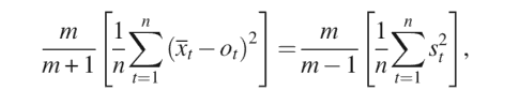
-- Leutbecher and Palmer 2008

Binned Spread-Skill plot shows the calibration of an ensemble and is formed by the equation above see Leutbecher and Palmer 2008 for more detail. The plot is meant to show how variations in the ensemble spread can predict variations in the ensemble accuracy, where a perfectly calibrated ensemble falls direction on the 1:1 line.

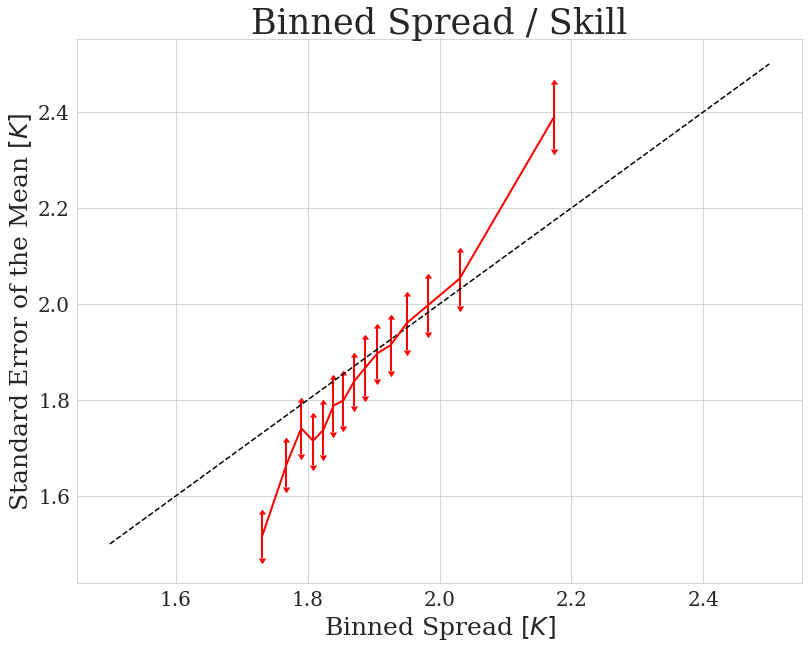

In [65]:
nobins=15 # number of bins to seperate the spread skill
nomems=40 # number of ensemble members to create
[avgvar_m,msebin_m,avgvar_s,msebin_s] = spreadskill(np.array(results_df['Emos_mean']),np.array(results_df['Obs'])
                                                    ,-1*np.array(results_df['Emos_std']),nobins,nomems)
    
###### plot: ######
# fcast = 'F'+f'{((forenumb+1)*6):03}'
plt.figure(figsize=[13,10])  # inches

plt.errorbar(avgvar_m, msebin_m, xerr=avgvar_s, yerr=3*msebin_s, uplims=True, lolims=True,color='r',linewidth=2)

plt.ylabel('Standard Error of the Mean $[K]$',fontsize=25)
plt.xlabel('Binned Spread $[K]$',fontsize=25)

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.title('Binned Spread / Skill',fontsize=35)

plt.plot([1.5,2.5],[1.5,2.5],'k--')
plt.show()

## Rank Histogram
First let's create an ensemble by sampling from the defined parametric distributions: N(mean,std). Rank Histograms as detailed by Hamill 2001, show the frequnency in which a observation lands the ranked position of an ensemble. A perfectly calibrate ensmeble will have a flat rank histogram. Each forecast creates the histogram bins and these forecasts are "ranked" from highest to lowest, the observation then populates the bin in which it falls. In a calibrated ensemble forecast the observation will fall into the each bin an equal number of times. 

In [66]:
ense_num = 15 #number of ensembles to generate.: 
enseGEN = np.zeros([ense_num,results_df.shape[0]])

for ii in range(results_df.shape[0]):
    nummer = np.random.normal(np.array(results_df['Emos_mean'])[ii],
                              np.abs(np.array(results_df['Emos_std'])[ii]),ense_num)
    
    enseGEN[:,ii] = (nummer)


computing ranks
computing ties


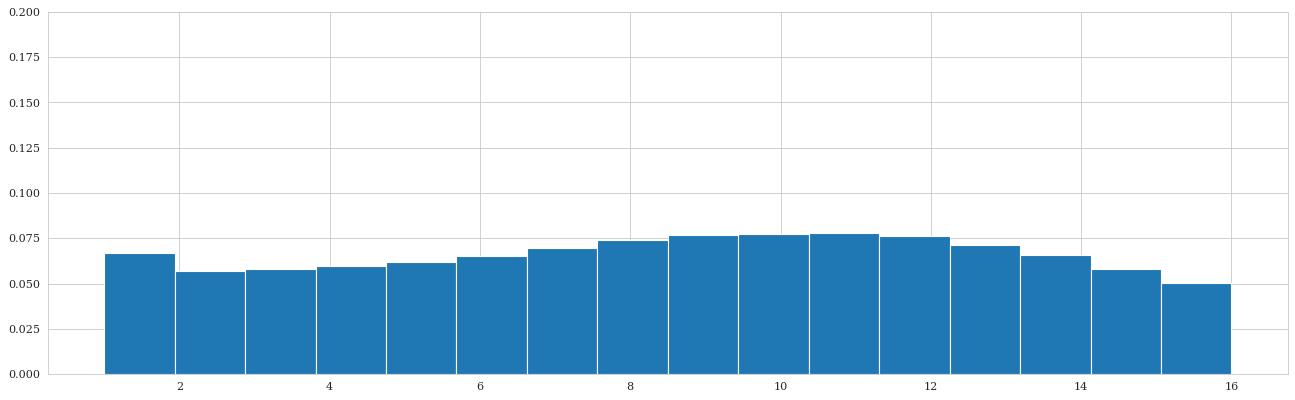

In [67]:
#rank histogram:
rr = ranker(results_df['Obs'],enseGEN)
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(rr,density=True,bins=ense_num+1)
plt.ylim([0,0.20])
plt.show()